In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba
import os

|          | **Descripción**                   | **Propensidad**                                                                                                                                                          | **Reacción**                                                                               | **Compartimento** |
|----------|-----------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------|-------------------|
| $s_{0}$  | Creación $lasR$                   | $\kappa_{lasR}$                                                                                                                                                          | $lasR\to lasR+1$                                                                             | b                 |
| $s_{1}$  | Degradación $lasR$                | $lasR*\gamma_{lasR}$                                                                                                                                                     | $lasR\to lasR-1$                                                                             | b                 |
| $s_{2}$  | Creación $LasR$                   | $lasR*\kappa_{LasR}$                                                                                                                                                     | $LasR\to LasR+1$                                                                             | b                 |
| $s_{3}$  | Unión $AI_1 + LasR$               | $AI_1*LasR*\mu_{A1{\cdot}LasR}$                                                                                                                                          | $AI_1\to AI_1-1$ <br /> $R\to Las{\cdot}LasR-1$ <br /> $AI_1{\cdot}LasR\to AI_1{\cdot}LasR+1$    | b                 |
| $s_{4}$  | Rompimiento $AI_{1}{\cdot}LasR$   | $AI_{1}{\cdot}LasR*\sigma_{AI1{\cdot}LasR}$                                                                                                                              | $AI_1\to AI_1+1$ <br /> $LasR\to LasR+1$ <br /> $AI_1{\cdot}LasR\to AI_1{\cdot}LasR-1$           | b                 |
| $s_{5}$  | Degradación $LasR$                | $LasR*\gamma_{LasR}$                                                                                                                                                     | $LasR\to LasR-1$                                                                             | b                 |
| $s_{6}$  | Creación $rsaL$                   | $\alpha_{rsaL}+\beta_{rsaL}\frac{K_{1}^{h_{1}}}{(K_{1}^{h_{1}} + LasR{\cdot}AI_1^{h_{1}})}$                                                                              | $rsaL\to rsaL+1$                                                                             | b                 |
| $s_{7}$  | Degradación $rsaL$                | $rsaL*\gamma_{rsaL}$                                                                                                                                                     | $rsaL\to rsaL-1$                                                                             | b                 |
| $s_{8}$  | Creación $RsaL$                   | $rsaL*\kappa_{RsaL}$                                                                                                                                                     | $RsaL\to RsaL+1$                                                                             | b                 |
| $s_{9}$  | Degradación $RsaL$                | $RsaL*\gamma_{RsaL}$                                                                                                                                                     | $RsaL\to RsaL-1$                                                                             | b                 |
| $s_{10}$ | Creación $lasI$                   | $\alpha_{lasI}+\beta_{lasI}\frac{K_{2}^{h_{2}}}{(K_{2}^{h_{2}} + LasR{\cdot}AI_1^{h_{2}})}$ <br /> $+ \beta_{lasI}\frac{K_{3}^{h_{3}}}{(K_{3}^{h_{3}} + RsaL^{h_{3}})}$  | $lasI\to lasI+1$                                                                             | b                 |
| $s_{11}$ | Degradación $lasI$                | $lasI*\gamma_{lasI}$                                                                                                                                                     | $lasI\to lasI-1$                                                                             | b                 |
| $s_{12}$ | Creación $LasI$                   | $lasI*\kappa_{LasI}$                                                                                                                                                     | $LasI\to LasI+1$                                                                             | b                 |
| $s_{13}$ | Degradación $LasI$                | $LasI*\gamma_{LasI}$                                                                                                                                                     | $LasI\to LasI-1$                                                                             | b                 |
| $s_{14}$ | Creación $A1_1$                   | $LasI*\kappa_{AI_1}$                                                                                                                                                     | $A1_1\to A1_1+1$                                                                             | b                 |
| $s_{15}$ | Degradación $A1_1$                | $AI_1*\gamma_{AI_1}$                                                                                                                                                     | $AI_1\to AI_1-1$                                                                             | b                 |
| $s_{16}$ | Difusión $A_1$                    | $AI_1*d$                                                                                                                                                                 | $AI_1\to AI_1-1$ <br /> $AI_{1ext}\to AI_{1ext}+1$                                             | b                 |
| $s_{17}$ | Degradación $AI_{1}{\cdot}LasR$   | $AI_{1}{\cdot}LasR*\gamma_{AI1{\cdot}LasR}$                                                                                                                              | $AI_1{\cdot}LasR\to AI_1{\cdot}LasR-1$                                                       | b                 |
| $s_{18}$ | Difusión $AI_{1ext}$       | $AI_{1ext}*d$                                                                                                                                                                   | $AI_1\to AI_1+1$ <br /> $AI_{1ext}\to AI_{1ext}-1$                                             | e                 |
| $s_{19}$ | Degradación $AI_{1ext}$    | $AI_{1ext}*(\gamma_{A1}+d_{away)}$                                                                                                                                              | $AI_{1ext}\to AI_{1ext}-1$                                                                   | e                 |

In [2]:
# @numba.njit
def b_rules(x):
    
    lasR, LasR, lasI, LasI, AI1, LasRAI1 = x
    
    k_lasR = 0.004
    g_lasR = 0.002
    k_LasR = 0.4
    g_LasR = 0.35
    a_lasI = 0.00036
    b_lasI = 0.0058
    K1 = 1.2
    h1 = -1.4
    g_lasI = 0.001
    k_LasI = 0.7
    g_LasI = 0.12
    k_AI1 = 1
    g_AI1 = 0.3
    u_LasRAI1 = 0.05
    s_LasRAI1 = 0.25
    g_LasRAI1 = 0.14
    # Cell parameters
    d = 0.8
    
    S0 = k_lasR                                       # + lasR
    S1 = lasR*g_lasR                                  # - lasR
    S2 = lasR*k_LasR                                  # + LasR
    S3 = LasRAI1*s_LasRAI1                            # + LasR ; + AI1 ; - LasRAI1
    S4 = AI1*LasR*u_LasRAI1                           # - LasR ; - AI1 ; + LasRAI1
    S5 = LasR*g_LasR                                  # - LasR
    S6 = a_lasI + (b_lasI/(1+(LasRAI1/K1)**h1))       # + lasI
    S7 = lasI*g_lasI                                  # - lasI
    S8 = lasI*k_LasI                                  # + LasI
    S9 = LasI*g_LasI                                  # - LasI
    S10 = LasI*k_AI1                                  # + AI1
    S11 = AI1*g_AI1                                   # - AI1
    S12 = d*AI1                                       # - AI1 ; + AI1_ext
    S13 = LasRAI1*g_LasRAI1                           # - LasRAI1
    
    Stot = S0 + S1 + S2 + S3 + S4 + S5 + S6 + S7 + S8 + S9 + S10 + S11 + S12 + S13
    
    U = np.random.rand()
    Tau = np.random.exponential(scale=1/Stot)
    
    if (U < S0/Stot):
        return np.array((U, Tau, 0), dtype=[('u','f4'), ('tau','f4'), ('j','i4')])
    elif (U < (S0+S1)/Stot):
        return np.array((U, Tau, 1), dtype=[('u','f4'), ('tau','f4'), ('j','i4')])
    elif (U < (S0+S1+S2)/Stot):
        return np.array((U, Tau, 2), dtype=[('u','f4'), ('tau','f4'), ('j','i4')])
    elif (U < (S0+S1+S2+S3)/Stot):
        return np.array((U, Tau, 3), dtype=[('u','f4'), ('tau','f4'), ('j','i4')])
    elif (U < (S0+S1+S2+S3+S4)/Stot):
        return np.array((U, Tau, 4), dtype=[('u','f4'), ('tau','f4'), ('j','i4')])
    elif (U < (S0+S1+S2+S3+S4+S5)/Stot):
        return np.array((U, Tau, 5), dtype=[('u','f4'), ('tau','f4'), ('j','i4')])
    elif (U < (S0+S1+S2+S3+S4+S5+S6)/Stot):
        return np.array((U, Tau, 6), dtype=[('u','f4'), ('tau','f4'), ('j','i4')])
    elif (U < (S0+S1+S2+S3+S4+S5+S6+S7)/Stot):
        return np.array((U, Tau, 7), dtype=[('u','f4'), ('tau','f4'), ('j','i4')])
    elif (U < (S0+S1+S2+S3+S4+S5+S6+S7+S8)/Stot):
        return np.array((U, Tau, 8), dtype=[('u','f4'), ('tau','f4'), ('j','i4')])
    elif (U < (S0+S1+S2+S3+S4+S5+S6+S7+S8+S9)/Stot):
        return np.array((U, Tau, 9), dtype=[('u','f4'), ('tau','f4'), ('j','i4')])
    elif (U < (S0+S1+S2+S3+S4+S5+S6+S7+S8+S9+S10)/Stot):
        return np.array((U, Tau, 10), dtype=[('u','f4'), ('tau','f4'), ('j','i4')])
    elif (U < (S0+S1+S2+S3+S4+S5+S6+S7+S8+S9+S10+S11)/Stot):
        return np.array((U, Tau, 11), dtype=[('u','f4'), ('tau','f4'), ('j','i4')])
    elif (U < (S0+S1+S2+S3+S4+S5+S6+S7+S8+S9+S10+S11+S12)/Stot):
        return np.array((U, Tau, 12), dtype=[('u','f4'), ('tau','f4'), ('j','i4')])
    else:
        return np.array((U, Tau, 13), dtype=[('u','f4'), ('tau','f4'), ('j','i4')])

In [3]:
# @numba.njit
def e_rules(x):
    
    AI1_ext = x
    
    g_AI1_ext = 0.8
    d = 0.8
    d_away = 1.2
    
    if AI1_ext == 0:
        U = np.random.rand()
        Tau = np.random.exponential(scale=d+d_away+g_AI1_ext)                        
        return np.array((U, Tau, 99), dtype=[('u','f4'), ('tau','f4'), ('j','i4')])  # 99 denotes no reaction
    else:
        S14 = AI1_ext*d                       # + AI1 ; - AI1_ext
        S15 = AI1_ext*(d_away + g_AI1_ext)    # - AI1_ext
    
        Stot = S14 + S15
    
        U = np.random.rand()
        Tau = np.random.exponential(scale=1/Stot)
    
        if (U < S14/Stot):
            return np.array((U, Tau, 14), dtype=[('u','f4'), ('tau','f4'), ('j','i4')])
        else:
            return np.array((U, Tau, 15), dtype=[('u','f4'), ('tau','f4'), ('j','i4')])

In [34]:
# @numba.njit
def multicompartmental_gillespie(N=10, steps=500, b_0=np.array([1, 5, 1, 1, 5, 5]), e_0=np.array([0])):
    
    if os.path.exists('bacteria.tsv'):
        os.remove('bacteria.tsv')
    if os.path.exists('environment.tsv'):
        os.remove('environment.tsv')
    
    # Initial conditions
    t = 0

    # Simulation initialization
    bacteria = np.zeros([N, len(b_0)])
    i = 0
    while i < N:
        x = 0
        while x < len(b_0):
            bacteria[i,x] = b_0[x]
            x += 1
        i += 1
    bacteria_file = pd.DataFrame(bacteria, columns=['lasR', 'LasR', 'lasI', 'LasI', 'AI1', 'LasRAI1'])
    bacteria_file.insert(0, 't', np.zeros(N))
    bacteria_file.insert(0, 'cell', np.array(range(N)))
    bacteria_file.set_index('cell', inplace=True)
    bacteria_file.to_csv('bacteria.tsv', sep='\t')
    del bacteria_file

    env = np.zeros(len(e_0))
    x = 0
    while x < len(e_0):
        env[x] = e_0[x]
        x += 1
    env_file = pd.DataFrame(env, columns=['AI1_ext'])
    env_file.insert(0, 't', np.zeros(1))
    env_file.set_index('t', inplace=True)
    env_file.to_csv('environment.tsv', sep='\t')
    del env_file
    
    # Simulation
    step = 0
    while step < steps:
        reactions = np.zeros(N+1, dtype=[('tau','f4'), ('j','i4'), ('i','i4')])
        i = 0
        while i < N:
            reactions[i]['tau'] = b_rules(bacteria[i])['tau']
            reactions[i]['j'] = b_rules(bacteria[i])['j']
            reactions[i]['i'] = i
            i += 1
        reactions[N]['tau'] = e_rules(env[0])['tau']
        reactions[N]['j'] = e_rules(env[0])['j']
        reactions[N]['i'] = N
        
        reactions_sorted = np.sort(reactions, order='tau')
        
        h = 0
        # t += reactions_sorted[0]['tau']
        for reaction_sorted in reactions_sorted:
            if reaction_sorted['i'] == N:
                if reaction_sorted['j'] == 99:
                    t += reaction_sorted['tau']
                    env[0] = env[0]
                    with open('environment.tsv', 'a') as env_file:
                        env_file.write(f'{t}\t')
                        env_file.write(f'{env[0]}')
                        env_file.write(f'\n')
                elif reaction_sorted['j'] == 14:
                    t += reaction_sorted['tau']
                    i = np.random.randint(0,N)
                    bacteria[i,4] = bacteria[i,4]+1
                    env[0] = env[0]-1
                    with open('bacteria.tsv', 'a') as bacteria_file:
                        bacteria_file.write(f'{i}\t')
                        bacteria_file.write(f'{t}\t')
                        x = 0
                        while x < len(bacteria[i]):
                            if x == len(bacteria[i])-1:
                                bacteria_file.write(f'{bacteria[i,x]}')
                            else:
                                bacteria_file.write(f'{bacteria[i,x]}\t')
                            x += 1
                        bacteria_file.write(f'\n')
                    with open('environment.tsv', 'a') as env_file:
                        env_file.write(f'{t}\t')
                        env_file.write(f'{env[0]}')
                        env_file.write(f'\n')
                else:
                    t += reaction_sorted['tau']
                    env[0] = env[0]-1
                    with open('environment.tsv', 'a') as env_file:
                        env_file.write(f'{t}\t')
                        env_file.write(f'{env[0]}')
                        env_file.write(f'\n')

            else:
                if reaction_sorted['j'] == 0:
                    t += reaction_sorted['tau']
                    i = reaction_sorted['i']
                    bacteria[i,0] = bacteria[i,0]+1
                    with open('bacteria.tsv', 'a') as bacteria_file:
                        bacteria_file.write(f'{i}\t')
                        bacteria_file.write(f'{t}\t')
                        x = 0
                        while x < len(bacteria[i]):
                            if x == len(bacteria[i])-1:
                                bacteria_file.write(f'{bacteria[i,x]}')
                            else:
                                bacteria_file.write(f'{bacteria[i,x]}\t')
                            x += 1
                        bacteria_file.write(f'\n')
                elif reaction_sorted['j'] == 1:
                    t += reaction_sorted['tau']
                    i = reaction_sorted['i']
                    bacteria[i,0] = bacteria[i,0]-1
                    with open('bacteria.tsv', 'a') as bacteria_file:
                        bacteria_file.write(f'{i}\t')
                        bacteria_file.write(f'{t}\t')
                        x = 0
                        while x < len(bacteria[i]):
                            if x == len(bacteria[i])-1:
                                bacteria_file.write(f'{bacteria[i,x]}')
                            else:
                                bacteria_file.write(f'{bacteria[i,x]}\t')
                            x += 1
                        bacteria_file.write(f'\n')
                elif reaction_sorted['j'] == 2:
                    t += reaction_sorted['tau']
                    i = reaction_sorted['i']
                    bacteria[i,1] = bacteria[i,1]+1
                    with open('bacteria.tsv', 'a') as bacteria_file:
                        bacteria_file.write(f'{i}\t')
                        bacteria_file.write(f'{t}\t')
                        x = 0
                        while x < len(bacteria[i]):
                            if x == len(bacteria[i])-1:
                                bacteria_file.write(f'{bacteria[i,x]}')
                            else:
                                bacteria_file.write(f'{bacteria[i,x]}\t')
                            x += 1
                        bacteria_file.write(f'\n')
                elif reaction_sorted['j'] == 3:
                    t += reaction_sorted['tau']
                    i = reaction_sorted['i']
                    bacteria[i,1] = bacteria[i,1]+1
                    bacteria[i,4] = bacteria[i,4]+1
                    bacteria[i,5] = bacteria[i,5]-1
                    with open('bacteria.tsv', 'a') as bacteria_file:
                        bacteria_file.write(f'{i}\t')
                        bacteria_file.write(f'{t}\t')
                        x = 0
                        while x < len(bacteria[i]):
                            if x == len(bacteria[i])-1:
                                bacteria_file.write(f'{bacteria[i,x]}')
                            else:
                                bacteria_file.write(f'{bacteria[i,x]}\t')
                            x += 1
                        bacteria_file.write(f'\n')
                elif reaction_sorted['j'] == 4:
                    t += reaction_sorted['tau']
                    i = reaction_sorted['i']
                    bacteria[i,1] = bacteria[i,1]-1
                    bacteria[i,4] = bacteria[i,4]-1
                    bacteria[i,5] = bacteria[i,5]+1
                    with open('bacteria.tsv', 'a') as bacteria_file:
                        bacteria_file.write(f'{i}\t')
                        bacteria_file.write(f'{t}\t')
                        x = 0
                        while x < len(bacteria[i]):
                            if x == len(bacteria[i])-1:
                                bacteria_file.write(f'{bacteria[i,x]}')
                            else:
                                bacteria_file.write(f'{bacteria[i,x]}\t')
                            x += 1
                        bacteria_file.write(f'\n')
                elif reaction_sorted['j'] == 5:
                    t += reaction_sorted['tau']
                    i = reaction_sorted['i']
                    bacteria[i,1] = bacteria[i,1]-1
                    with open('bacteria.tsv', 'a') as bacteria_file:
                        bacteria_file.write(f'{i}\t')
                        bacteria_file.write(f'{t}\t')
                        x = 0
                        while x < len(bacteria[i]):
                            if x == len(bacteria[i])-1:
                                bacteria_file.write(f'{bacteria[i,x]}')
                            else:
                                bacteria_file.write(f'{bacteria[i,x]}\t')
                            x += 1
                        bacteria_file.write(f'\n')
                elif reaction_sorted['j'] == 6:
                    t += reaction_sorted['tau']
                    i = reaction_sorted['i']
                    bacteria[i,2] = bacteria[i,2]+1
                    with open('bacteria.tsv', 'a') as bacteria_file:
                        bacteria_file.write(f'{i}\t')
                        bacteria_file.write(f'{t}\t')
                        x = 0
                        while x < len(bacteria[i]):
                            if x == len(bacteria[i])-1:
                                bacteria_file.write(f'{bacteria[i,x]}')
                            else:
                                bacteria_file.write(f'{bacteria[i,x]}\t')
                            x += 1
                        bacteria_file.write(f'\n')
                elif reaction_sorted['j'] == 7:
                    t += reaction_sorted['tau']
                    i = reaction_sorted['i']
                    bacteria[i,2] = bacteria[i,2]-1
                    with open('bacteria.tsv', 'a') as bacteria_file:
                        bacteria_file.write(f'{i}\t')
                        bacteria_file.write(f'{t}\t')
                        x = 0
                        while x < len(bacteria[i]):
                            if x == len(bacteria[i])-1:
                                bacteria_file.write(f'{bacteria[i,x]}')
                            else:
                                bacteria_file.write(f'{bacteria[i,x]}\t')
                            x += 1
                        bacteria_file.write(f'\n')

                elif reaction_sorted['j'] == 8:
                    t += reaction_sorted['tau']
                    i = reaction_sorted['i']
                    bacteria[i,3] = bacteria[i,3]+1
                    with open('bacteria.tsv', 'a') as bacteria_file:
                        bacteria_file.write(f'{i}\t')
                        bacteria_file.write(f'{t}\t')
                        x = 0
                        while x < len(bacteria[i]):
                            if x == len(bacteria[i])-1:
                                bacteria_file.write(f'{bacteria[i,x]}')
                            else:
                                bacteria_file.write(f'{bacteria[i,x]}\t')
                            x += 1
                        bacteria_file.write(f'\n')
                elif reaction_sorted['j'] == 9:
                    t += reaction_sorted['tau']
                    i = reaction_sorted['i']
                    bacteria[i,3] = bacteria[i,3]-1
                    with open('bacteria.tsv', 'a') as bacteria_file:
                        bacteria_file.write(f'{i}\t')
                        bacteria_file.write(f'{t}\t')
                        x = 0
                        while x < len(bacteria[i]):
                            if x == len(bacteria[i])-1:
                                bacteria_file.write(f'{bacteria[i,x]}')
                            else:
                                bacteria_file.write(f'{bacteria[i,x]}\t')
                            x += 1
                        bacteria_file.write(f'\n')
                elif reaction_sorted['j'] == 10:
                    t += reaction_sorted['tau']
                    i = reaction_sorted['i']
                    bacteria[i,4] = bacteria[i,4]+1
                    with open('bacteria.tsv', 'a') as bacteria_file:
                        bacteria_file.write(f'{i}\t')
                        bacteria_file.write(f'{t}\t')
                        x = 0
                        while x < len(bacteria[i]):
                            if x == len(bacteria[i])-1:
                                bacteria_file.write(f'{bacteria[i,x]}')
                            else:
                                bacteria_file.write(f'{bacteria[i,x]}\t')
                            x += 1
                        bacteria_file.write(f'\n')
                elif reaction_sorted['j'] == 11:
                    t += reaction_sorted['tau']
                    i = reaction_sorted['i']
                    bacteria[i,4] = bacteria[i,4]-1
                    with open('bacteria.tsv', 'a') as bacteria_file:
                        bacteria_file.write(f'{i}\t')
                        bacteria_file.write(f'{t}\t')
                        x = 0
                        while x < len(bacteria[i]):
                            if x == len(bacteria[i])-1:
                                bacteria_file.write(f'{bacteria[i,x]}')
                            else:
                                bacteria_file.write(f'{bacteria[i,x]}\t')
                            x += 1
                        bacteria_file.write(f'\n')
                elif reaction_sorted['j'] == 12:
                    t += reaction_sorted['tau']
                    env[0] = env[0]+1
                    i = reaction_sorted['i']
                    bacteria[i,4] = bacteria[i,4]+1
                    with open('bacteria.tsv', 'a') as bacteria_file:
                        bacteria_file.write(f'{i}\t')
                        bacteria_file.write(f'{t}\t')
                        x = 0
                        while x < len(bacteria[i]):
                            if x == len(bacteria[i])-1:
                                bacteria_file.write(f'{bacteria[i,x]}')
                            else:
                                bacteria_file.write(f'{bacteria[i,x]}\t')
                            x += 1
                        bacteria_file.write(f'\n')
                    with open('environment.tsv', 'a') as env_file:
                        env_file.write(f'{t}\t')
                        env_file.write(f'{env[0]}')
                        env_file.write(f'\n')
                else:
                    t += reaction_sorted['tau']
                    i = reaction_sorted['i']
                    bacteria[i,5] = bacteria[i,5]-1
                    with open('bacteria.tsv', 'a') as bacteria_file:
                        bacteria_file.write(f'{i}\t')
                        bacteria_file.write(f'{t}\t')
                        x = 0
                        while x < len(bacteria[i]):
                            if x == len(bacteria[i])-1:
                                bacteria_file.write(f'{bacteria[i,x]}')
                            else:
                                bacteria_file.write(f'{bacteria[i,x]}\t')
                            x += 1
                        bacteria_file.write(f'\n')
            h += 1
        step += 1
    print('Finish')

In [39]:
multicompartmental_gillespie(N=50, steps=5000, b_0=np.array([1, 5, 1, 1, 5, 10]))

/tmp/ipykernel_31756/3864841646.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  S6 = a_lasI + (b_lasI/(1+(LasRAI1/K1)**h1))       # + lasI


Finish


In [40]:
bacteria = pd.read_table('bacteria.tsv', sep='\t', index_col=0)
bacteria_grouped = [bacteria.loc[i] for i in range(10)]

environment = pd.read_table('environment.tsv', sep='\t', index_col=0)


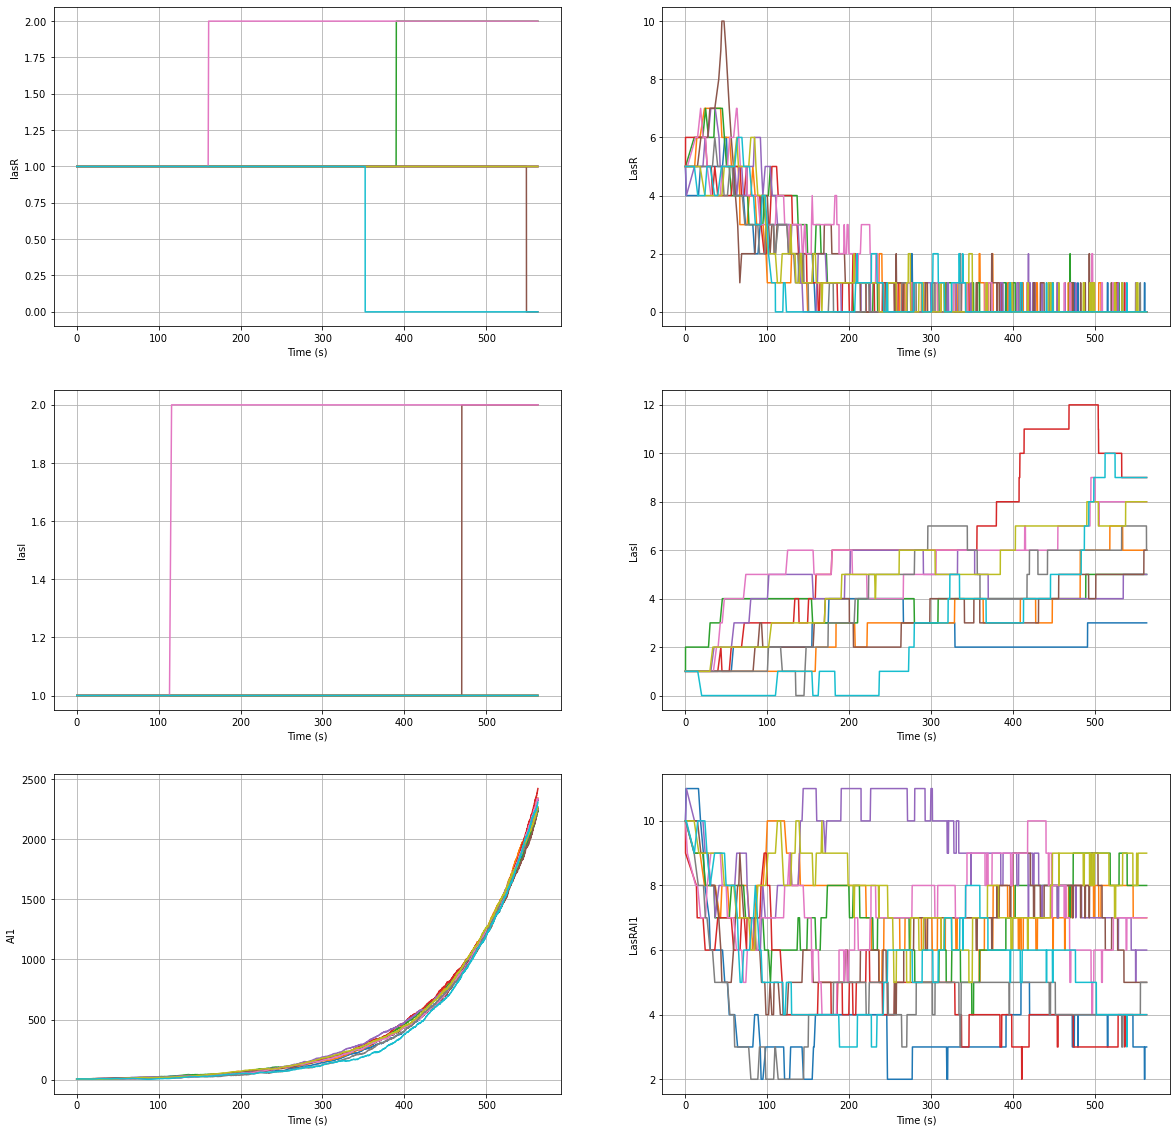

In [41]:
x = ['lasR', 'LasR', 'lasI', 'LasI', 'AI1', 'LasRAI1']
plt.figure(figsize=(20,20))
subplot = 1
for i in x:
    plt.subplot(3,2,subplot)
    for j in bacteria_grouped:
        plt.plot(j['t'], j[i])
    plt.xlabel('Time (s)')
    plt.ylabel(i)
    plt.grid()
    subplot += 1
plt.show()

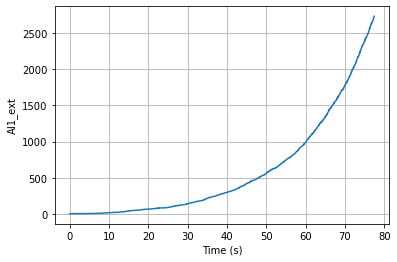

In [38]:
plt.plot(environment.index, environment['AI1_ext'])
plt.xlabel('Time (s)')
plt.ylabel('AI1_ext')
plt.grid()
plt.show()